# Tutorial: Applying Hard Constraints in PINNs to solve the Wave Problem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial3/tutorial.ipynb)

In this tutorial, we will present how to solve the wave equation using **hard constraint Physics-Informed Neural Networks (PINNs)**. To achieve this, we will build a custom `torch` model and pass it to the **PINN solver**.

First of all, some useful imports.

In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import matplotlib.pyplot as plt
import warnings

from pina import Condition, LabelTensor, Trainer
from pina.problem import SpatialProblem, TimeDependentProblem
from pina.domain import CartesianDomain
from pina.solver import PINN
from pina.equation import Equation, FixedValue
from pina.callback import MetricTracker
from pina.equation import AcousticWave

warnings.filterwarnings("ignore")

## The problem definition 

The problem is described by the following system of partial differential equations (PDEs):

\begin{equation}
\begin{cases}
\Delta u(x,y,t) = \frac{\partial^2}{\partial t^2} u(x,y,t) \quad \text{in } D, \\\\
u(x, y, t=0) = \sin(\pi x)\sin(\pi y), \\\\
u(x, y, t) = 0 \quad \text{on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}

Where:

- $D$ is a square domain $[0, 1]^2$.
- $\Gamma_i$, where $i = 1, \dots, 4$, are the boundaries of the square where Dirichlet conditions are applied.
- The velocity in the standard wave equation is fixed to $1$.

In [2]:
wave_equation = AcousticWave(c=1.0)


def initial_condition(input_, output_):
    u_expected = torch.sin(torch.pi * input_.extract(["x"])) * torch.sin(
        torch.pi * input_.extract(["y"])
    )
    return output_.extract(["u"]) - u_expected


class Wave(TimeDependentProblem, SpatialProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 1], "y": [0, 1]})
    temporal_domain = CartesianDomain({"t": [0, 1]})
    domains = {
        "D": spatial_domain.update(temporal_domain),
        "initial": spatial_domain.update(CartesianDomain({"t": 0.0})),
        "boundary": spatial_domain.partial().update(temporal_domain),
    }
    conditions = {
        "boundary": Condition(domain="boundary", equation=FixedValue(0.0)),
        "initial": Condition(
            domain="initial", equation=Equation(initial_condition)
        ),
        "D": Condition(domain="D", equation=wave_equation),
    }

    def solution(self, pts):
        f = (
            torch.sin(torch.pi * pts.extract(["x"]))
            * torch.sin(torch.pi * pts.extract(["y"]))
            * torch.cos(
                torch.sqrt(torch.tensor(2.0)) * torch.pi * pts.extract(["t"])
            )
        )
        return LabelTensor(f, self.output_variables)


# define problem
problem = Wave()

## Hard Constraint Model

Once the problem is defined, a **torch** model is needed to solve the PINN. While **PINA** provides several pre-implemented models, users have the option to build their own custom model using **torch**. The hard constraint we impose is on the boundary of the spatial domain. Specifically, the solution is written as:

$$ u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t), $$

where $NN$ represents the neural network output. This neural network takes the spatial coordinates $x$, $y$, and time $t$ as input and provides the unknown field $u$. By construction, the solution is zero at the boundaries.

The residuals of the equations are evaluated at several sampling points (which the user can manipulate using the `discretise_domain` method). The loss function minimized by the neural network is the sum of the residuals.

In [3]:
class HardMLP(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, output_dim),
        )

    # here in the foward we implement the hard constraints
    def forward(self, x):
        hard = (
            x.extract(["x"])
            * (1 - x.extract(["x"]))
            * x.extract(["y"])
            * (1 - x.extract(["y"]))
        )
        return hard * self.layers(x)

## Train and Inference
In this tutorial, the neural network is trained for 1000 epochs with a learning rate of 0.001 (default in `PINN`).

In [ ]:
# generate the data
problem.discretise_domain(1000, "random", domains="all")

# define model
model = HardMLP(len(problem.input_variables), len(problem.output_variables))

# crete the solver
pinn = PINN(problem=problem, model=model)

# create trainer and train
trainer = Trainer(
    solver=pinn,
    max_epochs=1000,
    accelerator="cpu",
    enable_model_summary=False,
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
    callbacks=[MetricTracker(["train_loss", "initial_loss", "D_loss"])],
)
trainer.train()

Let's now plot the losses inside `MetricTracker` to see how they vary during training.

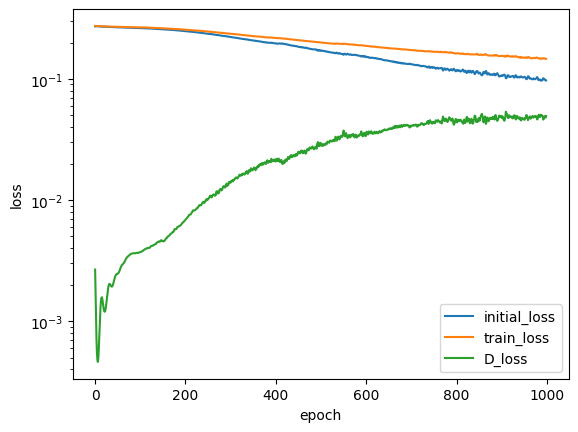

In [5]:
trainer_metrics = trainer.callbacks[0].metrics
for metric, loss in trainer_metrics.items():
    plt.plot(range(len(loss)), loss, label=metric)
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()

Notice that the loss on the boundaries of the spatial domain is exactly zero, as expected! Once the training is completed, we can plot the results using `matplotlib`. We will display the predicted output on the left side, the true solution in the center, and the difference between them on the right side using the `plot_solution` function.

In [6]:
@torch.no_grad()
def plot_solution(solver, time):
    # get the problem
    problem = solver.problem
    # get spatial points
    spatial_samples = problem.spatial_domain.sample(30, "grid")
    # get temporal value
    time = LabelTensor(torch.tensor([[time]]), "t")
    # cross data
    points = spatial_samples.append(time, mode="cross")
    # compute pinn solution, true solution and absolute difference
    data = {
        "PINN solution": solver(points),
        "True solution": problem.solution(points),
        "Absolute Difference": torch.abs(
            solver(points) - problem.solution(points)
        ),
    }
    # plot the solution
    plt.suptitle(f"Solution for time {time.item()}")
    for idx, (title, field) in enumerate(data.items()):
        plt.subplot(1, 3, idx + 1)
        plt.title(title)
        plt.tricontourf(  # convert to torch tensor + flatten
            points.extract("x").tensor.flatten(),
            points.extract("y").tensor.flatten(),
            field.tensor.flatten(),
        )
        plt.colorbar(), plt.tight_layout()

Let's take a look at the results at different times, for example `0.0`, `0.5` and `1.0`:

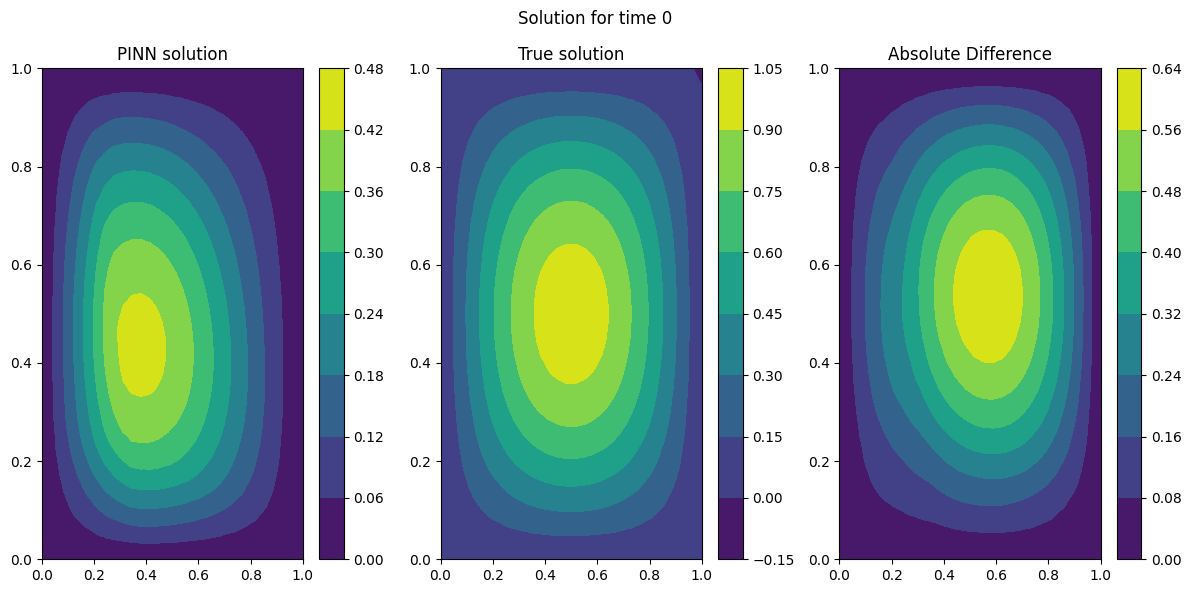

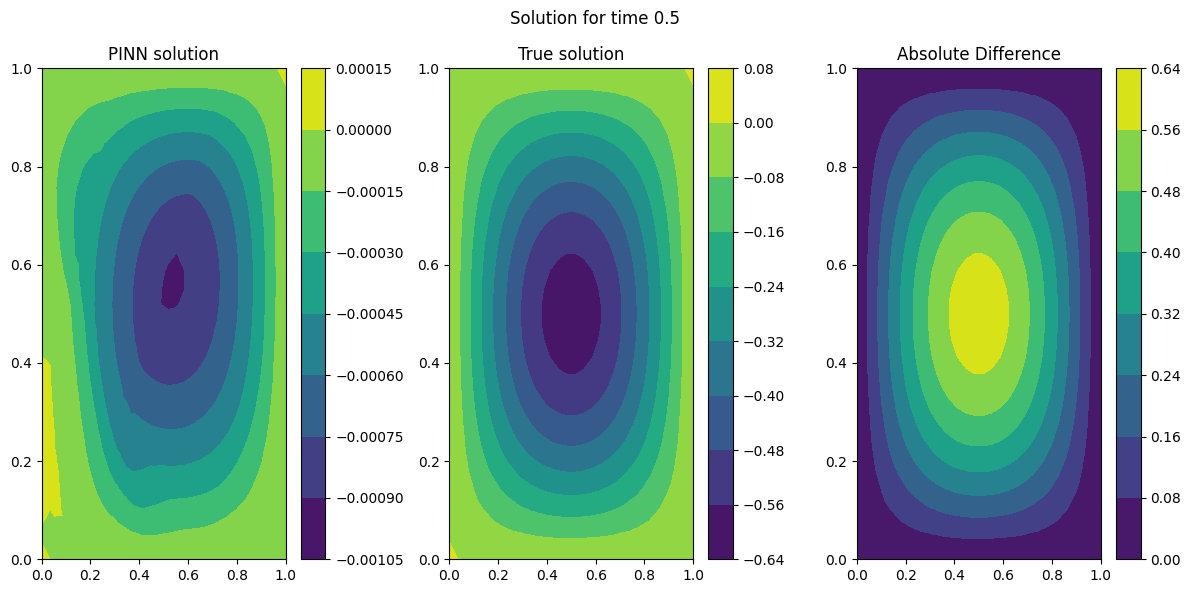

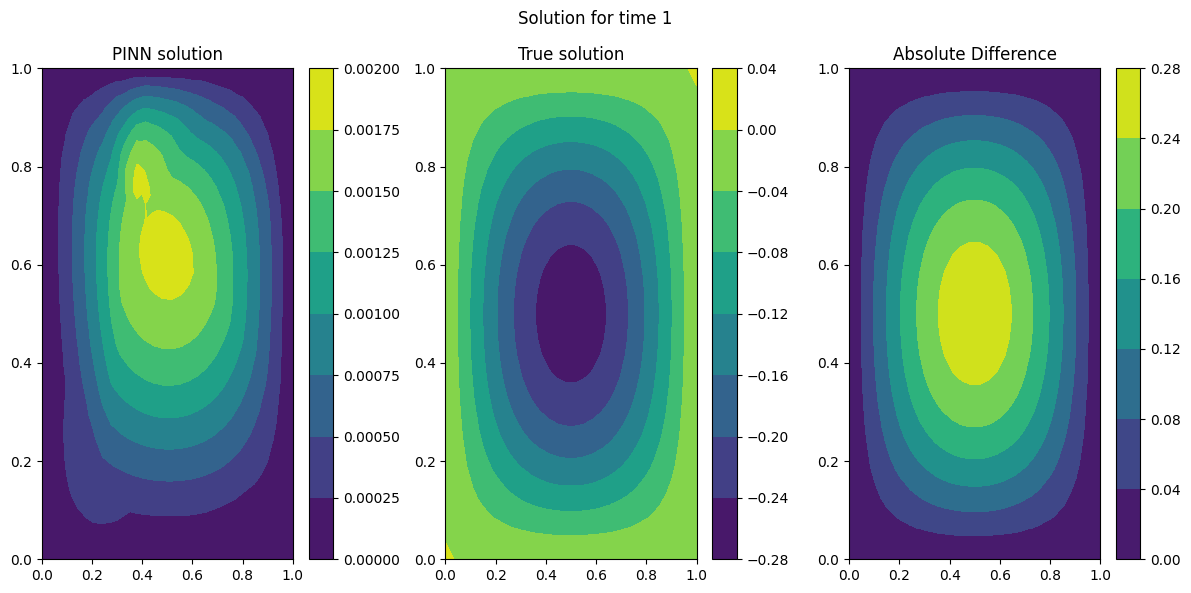

In [7]:
plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=0)

plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=0.5)

plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=1)

The results are not ideal, and we can clearly see that as time progresses, the solution deteriorates. Can we do better?

One valid approach is to impose the initial condition as a hard constraint as well. Specifically, we modify the solution to:

$$
u_{\rm{pinn}} = xy(1-x)(1-y) \cdot NN(x, y, t) \cdot t + \cos(\sqrt{2}\pi t)\sin(\pi x)\sin(\pi y),
$$

Now, let us start by building the neural network.

In [8]:
class HardMLPtime(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, 40),
            torch.nn.ReLU(),
            torch.nn.Linear(40, output_dim),
        )

    # here in the foward we implement the hard constraints
    def forward(self, x):
        hard_space = (
            x.extract(["x"])
            * (1 - x.extract(["x"]))
            * x.extract(["y"])
            * (1 - x.extract(["y"]))
        )
        hard_t = (
            torch.sin(torch.pi * x.extract(["x"]))
            * torch.sin(torch.pi * x.extract(["y"]))
            * torch.cos(
                torch.sqrt(torch.tensor(2.0)) * torch.pi * x.extract(["t"])
            )
        )
        return hard_space * self.layers(x) * x.extract(["t"]) + hard_t

Now let's train with the same configuration as the previous test

In [ ]:
# define model
model = HardMLPtime(len(problem.input_variables), len(problem.output_variables))

# crete the solver
pinn = PINN(problem=problem, model=model)

# create trainer and train
trainer = Trainer(
    solver=pinn,
    max_epochs=1000,
    accelerator="cpu",
    enable_model_summary=False,
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
    callbacks=[MetricTracker(["train_loss", "initial_loss", "D_loss"])],
)
trainer.train()

We can clearly see that the loss is way lower now. Let's plot the results

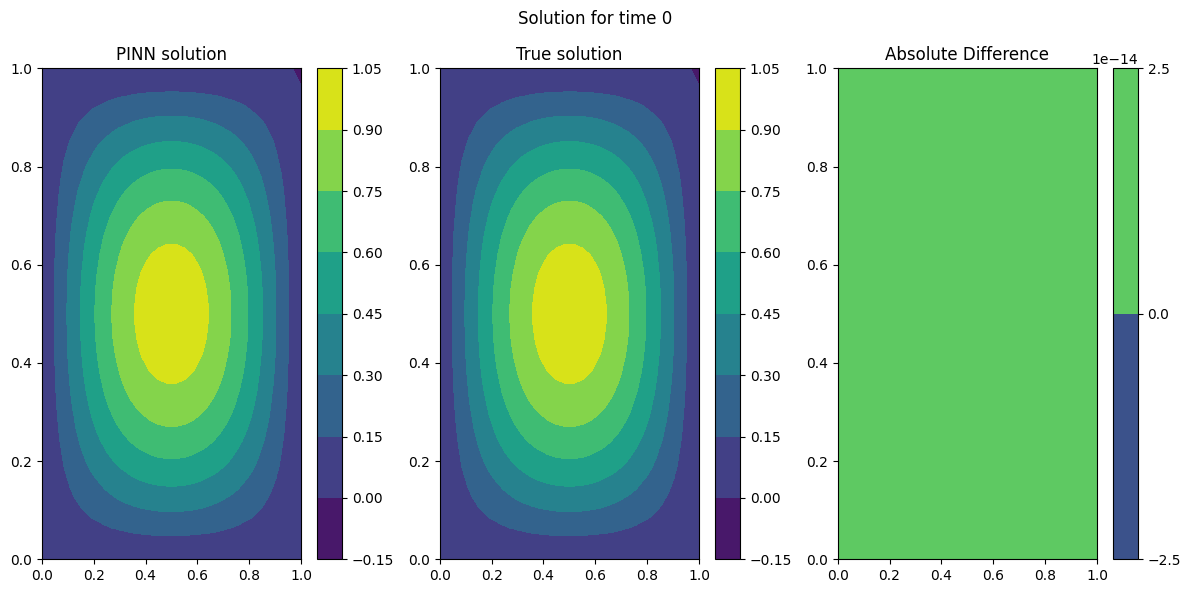

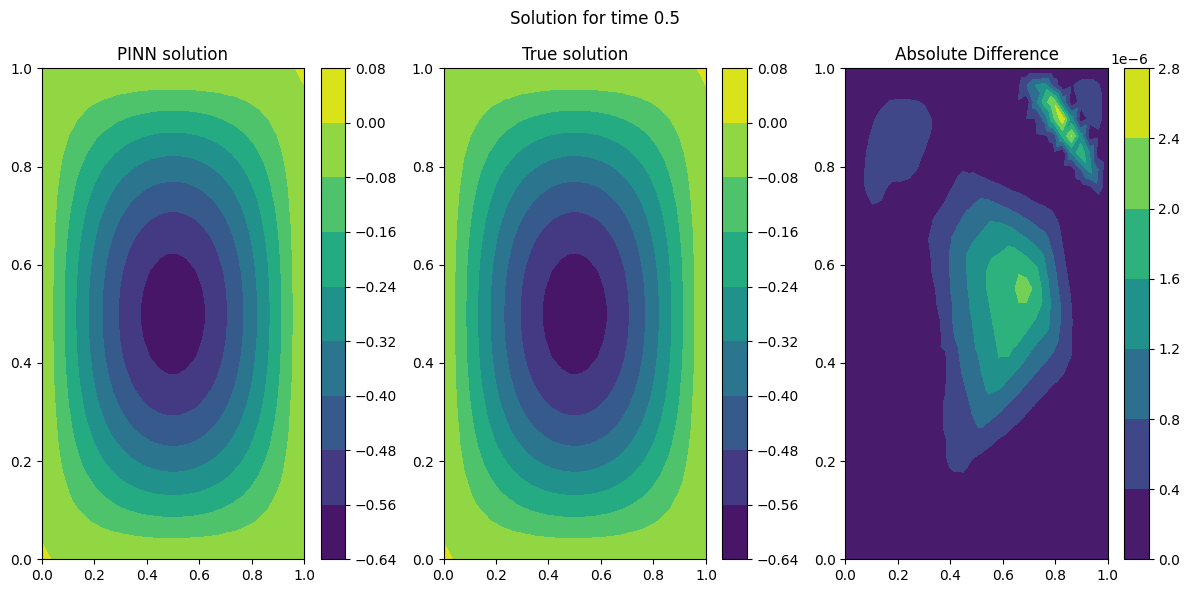

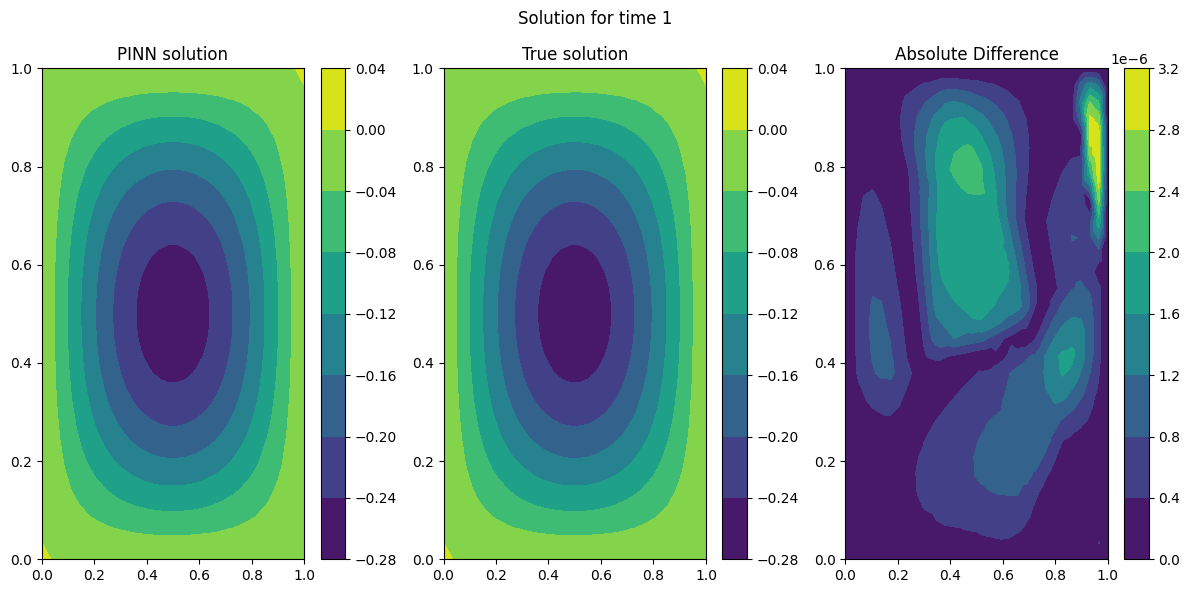

In [10]:
plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=0)

plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=0.5)

plt.figure(figsize=(12, 6))
plot_solution(solver=pinn, time=1)

We can now see that the results are much better! This improvement is due to the fact that, previously, the network was not correctly learning the initial condition, which led to a poor solution as time evolved. By imposing the initial condition as a hard constraint, the network is now able to correctly solve the problem.

## What's Next?

Congratulations on completing the two-dimensional Wave tutorial of **PINA**! Now that you’ve got the basics down, there are several directions you can explore:

1. **Train the Network for Longer**: Train the network for a longer duration or experiment with different layer sizes to assess the final accuracy.

2. **Propose New Types of Hard Constraints in Time**: Experiment with new time-dependent hard constraints, for example:
   
   $$
   u_{\rm{pinn}} = xy(1-x)(1-y)\cdot NN(x, y, t)(1-\exp(-t)) + \cos(\sqrt{2}\pi t)\sin(\pi x)\sin(\pi y)
   $$

3. **Exploit Extrafeature Training**: Apply extrafeature training techniques to improve models from 1 and 2.

4. **...and many more!**: The possibilities are endless! Keep experimenting and pushing the boundaries.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).